# Project 3: Multiplication rate across generations as a function of Aspect Ratio and Volume

**Research Question:** *How does the average multiplication rate across generations change as a function of the aspect ratio and area of the containing box?*

The intended purpose of this project is to explore the multiplication rate of the neutron system as a function of the aspect ratio of the box, the ratio of the width to the height, and the volume (area) of the box, the product of the width and the height. In particular, I want to see if this can hint at any bias in the Monte Carlo simulation method itself, and if particular aspect ratios are favored over others.

**Code Block Summary:** This is a little Jupyter hack for enabling equation numbering, for important derivations:

In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

**Code Block Summary:** Standard Imports.

In [2]:
import numpy as np
from matplotlib import pyplot as plt

**Code Block Summary:** Non-standard Imports. This project utilizes dataclasses [1](https://docs.python.org/3/library/dataclasses.html) for data storage, the collections deque [2](https://docs.python.org/3/library/collections.html#collections.deque) for non-recursive breadth-first-search, and pillow [3](https://pypi.org/project/pillow/) with io [4](https://docs.python.org/3/library/io.html) for image storage. Additionally, I'm using itertools [6](https://docs.python.org/3/library/itertools.html) to produce the list of coordinates making up a 3-D box from a list of dimensions and matplotlib's Axes3D [7](https://matplotlib.org/3.3.3/api/_as_gen/mpl_toolkits.mplot3d.axes3d.Axes3D.html) for plotting said boxes. Lastly, there is time [9](https://docs.python.org/3/library/time.html) for function timing (debugging information).

In [3]:
from dataclasses import dataclass
from collections import deque
from PIL import Image
import io

from itertools import product, combinations
from mpl_toolkits.mplot3d import Axes3D

import time

## (Non-Tree-Related) Helper Functions

**Code Block Summary:** (`save_graph_and_close`) Standard graph saving function. This is the description of this function from Project 2:
> This function saves graphs to memory to be stored into variables, and from there, I can called them again using `display`. This workflow makes managing the Jupyter notebook easy, and it also allows me to define all of my graphs together but display them in separate cells.

In [4]:
def save_graph_and_close():
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    graph = Image.open(buf)
    plt.close()
    return graph

## Tree Generation

**Code Block Summary:** (`get_next_neutron_position`) This function will randomly determine the ending position of a neutron given a starting position. It does this by first determining a random angular direction $\theta \in [0, 2\pi)$ and an azimuthal direction $\phi \in [0, \pi]$ to propagate in alongside a random distance calculated as $d \propto \exp(\lambda)$. From there, the new position can be calculated using the old position $\mathbf{r}_0$ as $$\mathbf{r} = \mathbf{r}_0 + d \langle \sin \phi \cos \theta, \sin \phi \sin \theta, \cos \phi \rangle$$

In [5]:
MEAN_FREE_PATH = 2.65

def get_next_neutron_position(current_position: np.array) -> np.array:
    """
    Generates a random direction for the neutron 
    and uses the mean-free-path to calculate the
    next position for the neutron.
    """
    theta = np.random.uniform(0, 2 * np.pi)
    phi   = np.random.uniform(0, np.pi)
    direction = np.array([ np.sin(phi) * np.cos(theta), np.sin(phi) * np.sin(theta), np.cos(phi) ])
    distance  = np.random.exponential(MEAN_FREE_PATH)
    
    return current_position + distance * direction

**Code Block Summary:** (`test_get_next_neutron_position`) Obtaining the next position for each neutron is an incredibly core function for this simulation, so a full testing suite is probably necessary.

In [6]:
def test_get_next_neutron_position(num_samples=100_000, tol=0.05):
    """
    Tests `get_next_neutron_position`
    """
    np.random.seed(0)
    current_position = np.zeros(3)
    
    positions = np.array([get_next_neutron_position(current_position) for _ in range(num_samples)])
    displacements = positions - current_position
    distances = np.linalg.norm(displacements, axis=1)
    
    # --- 1. Output shape check ---
    assert positions.shape == (num_samples, 3), "Output should be 3D positions"
    
    # --- 2. Mean displacement ≈ mean free path ---
    mean_distance = distances.mean()
    assert abs(mean_distance - MEAN_FREE_PATH) / MEAN_FREE_PATH < tol, \
        f"Mean distance {mean_distance:.2f} differs too much from expected {MEAN_FREE_PATH:.2f}"
    
    # --- 3. Direction uniformity check (mean of cos(theta) and sin(theta) near 0) ---
    directions = displacements / distances[:, None]
    mean_dir = np.mean(directions, axis=0)
    assert np.allclose(mean_dir, [0, 0, 0], atol=0.02), \
        f"Directions are not uniform (mean direction = {mean_dir})"
    
    # --- 4. Magnitude distribution sanity check (exponential shape) ---
    # Compare empirical mean to theoretical mean of exponential
    empirical_std = distances.std()
    theoretical_std = MEAN_FREE_PATH
    assert abs(empirical_std - theoretical_std) / theoretical_std < 0.1, \
        f"Standard deviation {empirical_std:.2f} should be near {theoretical_std:.2f}"
    
    print('Test Passed!')
    
test_get_next_neutron_position()

Test Passed!


**Code Block Summary:** (`class NeutronNode`) This is a structure to store Neutron information as a tree element. Each Neutron stores its own information (that being, it's starting position $\mathbf{r}_0$, ending position $\mathbf{r}_{1}$, and then whether or not it was lost) alongside a list of pointers to each of its "children" Neutrons.

In [7]:
@dataclass
class NeutronNode:
    start_pos: np.array          = None
    end_pos:   np.array          = None
    children:  list              = None
    lost:      bool              = False

**Code Block Summary:** (`EXAMPLE_TREE`) This is an example tree used for testing purposes, and it shows the power of the tree-based data structure for storing Neutron information.

In [8]:
EXAMPLE_TREE = NeutronNode(
        start_pos = np.array([0, 0, 0]), 
        end_pos   = np.array([1, 1, 0]),
        
        children  = [
            NeutronNode(
                start_pos = np.array([1, 1, 0]), 
                end_pos   = np.array([2, 1, 0]),
                
                children  = [
                    NeutronNode(
                        start_pos = np.array([2, 1, 0]),
                        end_pos   = np.array([4, 3, 0])
                    ),
                    
                    NeutronNode(
                        start_pos = np.array([2, 1, 0]),
                        end_pos   = np.array([3, 2, 0])
                    )
                ]
            ),
            
            NeutronNode(
                start_pos = np.array([1, 1, 0]), 
                end_pos   = np.array([1, 2, 0])
            )
        ]
    )

**Code Block Summary:** (`print_tree`) This is a simple recursive helper method to print a tree in a file-tree format, allowing for quick debugging of Neutron Trees.

In [9]:
def print_tree(node: NeutronNode, indent: int = 0):
    """
    Recursively pretty-print a neutron trajectory tree.
    """
    if node is None:
        print(" " * indent + "(empty node)")
        return
    
    space = "  " * indent
    start = tuple(np.round(node.start_pos, 2).tolist()) if node.start_pos is not None else None
    end   = tuple(np.round(node.end_pos, 2).tolist()) if node.end_pos is not None else None
    status = "lost" if node.lost else "active"
    
    print(f"{space}⤷ {status.upper()}  start={start}  →  end={end}")
    
    if node.children:
        for child in node.children:
            print_tree(child, indent + 1)
            
def test_print_tree():
    """
    Tests `print_tree` on EXAMPLE_TREE
    """
    print_tree(EXAMPLE_TREE)
    
test_print_tree()

⤷ ACTIVE  start=(0, 0, 0)  →  end=(1, 1, 0)
  ⤷ ACTIVE  start=(1, 1, 0)  →  end=(2, 1, 0)
    ⤷ ACTIVE  start=(2, 1, 0)  →  end=(4, 3, 0)
    ⤷ ACTIVE  start=(2, 1, 0)  →  end=(3, 2, 0)
  ⤷ ACTIVE  start=(1, 1, 0)  →  end=(1, 2, 0)


**Code Block Summary:** (`traverse_tree`) A non-recursive helper method for traversing a tree. It's used to simplify tree traversal from having to implement a tree traversal function each time with using Python's built-in collection iteration syntax, i.e.,
```python
for start_pos, end_pos, generation in traverse_tree(tree):
    do_something(start_pos, end_pos, generation)
```
This helper is implemented using non-recursive Breadth-first search [6](https://en.wikipedia.org/wiki/Breadth-first_search).

In [10]:
def traverse_tree(root: NeutronNode):
    """
    A simple method for traversing the tree using BFS
    without having to re-implement it each time.
    """
    if root is None:
        return

    # (node, generation)
    queue = deque([(root, 0)])

    while queue:
        node, generation = queue.popleft()

        # yield data for the current node
        yield node, generation

        # enqueue children if they exist
        if node.children:
            for child in node.children:
                queue.append((child, generation + 1))

def test_traverse_tree(debug_print: bool = False):
    if debug_print:
        for neutron, generation in traverse_tree(EXAMPLE_TREE):
            print(generation, neutron.start_pos, neutron.end_pos)
    
    assert len(list(traverse_tree(EXAMPLE_TREE))) == 5
    print("Test Passed!")
    
test_traverse_tree()

Test Passed!


In [11]:
def in_bound(value, bound):
    """
    Helper function to simplify bounds checking
    """
    return 0 <= value <= bound

def bounded_in_dimensions(pos, dimensions):
    """
    Checks to see if a position is within the given dimensions
    """
    bounded = True
    for i, dim in enumerate(dimensions):
        bounded = bounded and 0 <= pos[i] <= dim
    return bounded

**Code Block Summary** (`random_position_in_box`) This is a helper function for obtaining a random position within the box based on its dimensions $(w,h)$ for the sake of initial Neutron placement at the beginning of a tree.

In [12]:
def random_position_in_box(dimensions: tuple[float]) -> np.array:
    """
    Given `dimensions` = (width, length, height), returns
    a random (x,y,z) where 0 <= x <= width and
    0 <= y <= height.
    """
    return np.array([np.random.uniform(0, dim) for dim in dimensions])
    
def test_random_position_in_box():
    dim = (10,5,3)
    assert random_position_in_box(dim).size == 3

    pos = random_position_in_box(dim)
    assert bounded_in_dimensions(pos, dim)
    
    print('Test Passed!')
    
test_random_position_in_box()

Test Passed!


**Code Block Summary:** (`is_outside_box`) This is a helper method for determining whether a position $(x,y)$ is outside of the box given dimensions $(w,h)$, by checking if it is:
- Horizontally outside the box, to the left: $x < 0$
- Horizontally outside the box, to the right: $x > w$
- Vertically outside the box, below: $y < 0$
- Vertically outside the box, above: $y > h$

In [13]:
def is_outside_box(pos: np.array, dimensions: tuple[float]) -> bool:
    """
    Given pos        = (x, y, z), 
          dimensions = (w, l, h),
    returns if the position is outside of the dimensions.
    """
    return not bounded_in_dimensions(pos, dimensions)

def test_is_outside_box():
    dim = (10,5)
    
    assert is_outside_box(random_position_in_box(dim), dim) == False
    assert is_outside_box(np.array([0,   0]), dim) == False
    assert is_outside_box(np.array([10,  5]), dim) == False
    assert is_outside_box(np.array([11,  5]), dim) == True
    assert is_outside_box(np.array([-1, -1]), dim) == True
    
    print('Test Passed!')
    
test_is_outside_box()

Test Passed!


**Code Block Summary:** (`generate_children`) This function generates the list of children for a given node based on the starting position of the children (the ending position of the parent) $\mathbf{r}_0$, the number of children to be generated $n$, and the dimensions of the box $(w,h)$.

In [14]:
def generate_children(start_pos: np.array, n: int, dimensions: tuple[float]) -> list[NeutronNode]:
    """
    Given start_pos
    """
    children = []
    for _ in range(n):
        end_pos = get_next_neutron_position(start_pos)
        
        children.append(NeutronNode(
            start_pos = start_pos,
            end_pos   = end_pos,
            lost      = is_outside_box(end_pos, dimensions)
        ))
    return children

**Code Block Summary:** (`generate_tree_recursive`) This is a recursive helper function for performing the generative recursion necessary to build this tree. It was produced using the generative recursion template from CPSC 110 [5](https://cs110.students.cs.ubc.ca/reference/design-recipes.html#GenRec). Generation terminates for all nodes once reaching the generation limit and for any node that ends up becoming "lost" (or falls outside of the box on its end position). 

This is an in-place generative recursion, so no values are returned in this function, pointers are just appended to the end of the same tree.

In [15]:
def generate_tree_recursive(parent: NeutronNode, gen: int, max_generations: int, dimensions: tuple[float]):
    """
    Generates the neutron tree using in place tail recursion 
    """
    
    if gen >= max_generations or parent.lost:
        parent.children = []
        return
    
    parent.children = generate_children(parent.end_pos, 2, dimensions)
    for child in parent.children:
        generate_tree_recursive(child, gen + 1, max_generations, dimensions)

**Code Block Summary:** (`generate_tree`) This is the non-recursive root function used to begin the recursion necessary to build the Neutron tree using by initiating `generate_tree_recursive` given the number of generations and the dimensions of the box.

In [16]:
def generate_tree(num_generations: int, dimensions: tuple[float]) -> NeutronNode:
    """
    Calculates the trajectories (start and end points) for each 
    Neutron Generation by building a Neutron tree with BFS alongside
    the replication numbers for each generation transition.
    """
    initial_pos = random_position_in_box(dimensions)
    end_pos     = get_next_neutron_position(initial_pos)
    
    root = NeutronNode(
        start_pos = initial_pos,
        end_pos   = end_pos,
        lost      = is_outside_box(end_pos, dimensions)
    )
    
    generate_tree_recursive(root, 0, num_generations, dimensions)
    
    return root

**Code Block Summary** (`test_generate_tree`) This is a full testing suite for `generate_tree` which is entirely generated by ChatGPT. `generate_tree` is the most core function of this entire project, so it's absolutely imperative that this function works as-intended without issues. Therefore, I'm using a full, in-depth testing suite for this function.

In [17]:
import math

def test_generate_tree_structure():
    """Root should be a NeutronNode with valid positions."""
    root = generate_tree(3, (10, 10, 10))

    assert isinstance(root, NeutronNode), "Root must be NeutronNode"
    assert hasattr(root, "children"), "Root must have children list"

    assert len(root.start_pos) == 3, "Start position must be 3D"
    assert len(root.end_pos) == 3, "End position must be 3D"

    print("test_generate_tree_structure passed.")


def test_positions_validity():
    """
    Start must be inside the box; end may be inside or outside.
    """
    dims = (10, 10, 10)
    root = generate_tree(4, dims)

    assert bounded_in_dimensions(root.start_pos, dims), \
        "Initial position must be inside the box"

    print("test_positions_validity passed.")


def test_tree_depth():
    """
    Tree depth should not exceed num_generations.
    """
    dims = (10, 10, 10)
    gens = 4
    root = generate_tree(gens, dims)

    # BFS to compute max depth
    queue = [(root, 0)]
    max_depth = 0

    while queue:
        node, depth = queue.pop(0)
        max_depth = max(max_depth, depth)

        for child in node.children:
            queue.append((child, depth + 1))

    assert max_depth <= gens, "Tree depth exceeds num_generations"

    print("test_tree_depth passed.")


def test_lost_flag_correctness():
    """
    lost == True if and only if end_pos is outside box.
    """
    dims = (10, 10, 10)
    root = generate_tree(1, dims)

    expected = is_outside_box(root.end_pos, dims)
    assert root.lost == expected, "Lost flag does not match outside-box test"

    print("test_lost_flag_correctness passed.")


def test_multiple_generations_not_empty():
    """
    If num_generations > 0, root 
    should potentially have children.
    """
    dims = (10, 10, 10)
    root = generate_tree(3, dims)

    # Children may be zero if neutron is immediately lost,
    # but if not lost, we expect children
    if not root.lost:
        assert len(root.children) > 0, \
            "Root is not lost, but has no children!"

    print("test_multiple_generations_not_empty passed.")


def test_generate_tree():
    test_generate_tree_structure()
    test_positions_validity()
    test_tree_depth()
    test_lost_flag_correctness()
    test_multiple_generations_not_empty()
    print("\nALL TESTS PASSED!")


# Run them
test_generate_tree()

test_generate_tree_structure passed.
test_positions_validity passed.
test_tree_depth passed.
test_lost_flag_correctness passed.
test_multiple_generations_not_empty passed.

ALL TESTS PASSED!


## Plotting

**Code Block Summary:** (`class SimulationResult`) This is a structure for storing any graphs generated from a given simulation (if such graphs are generated under `simulate`) alongside the final Neutron tree(s) that are generated.

In [18]:
@dataclass
class SimulationResult:
    trajectories_graph: Image
    result_trees:       NeutronNode

**Code Block Summary** (`draw_3d_box`) This is a method to greatly simplify plotting a wireframe of the box on a 3-dimensional plot using only two sets of 3-dimensional coordinates (and origin point and the dimensions of the box). 

In [19]:
def draw_3d_box(ax, origin, dimensions, edgecolor='red', linestyle='dashed', linewidth=1):
    """
    Draws a 3D wireframe box on a given 3D axes.
    """
    # Define the 8 vertices of the box relative to the origin
    x_min, y_min, z_min = origin
    width, height, depth = dimensions
    x_max, y_max, z_max = x_min + width, y_min + height, z_min + depth

    # Create a list of all 8 vertex coordinates
    vertices = np.array(list(product([x_min, x_max], [y_min, y_max], [z_min, z_max])))

    # Draw the 12 edges by iterating over combinations of vertices
    for s, e in combinations(vertices, 2):
        # Only draw an edge if the vertices are connected along a single axis
        if np.sum(np.abs(s - e)) == width or np.sum(np.abs(s - e)) == height or np.sum(np.abs(s - e)) == depth:
            ax.plot3D(*zip(s, e), color=edgecolor, linestyle=linestyle, linewidth=linewidth)

**Code Block Summary:** (`plot_trajectories`) This function plots a 2-D graph of the trajectories of the Neutrons, producing the final tree-like structure colored and labelled by generation.

In [20]:
def plot_trajectories(trees: list[NeutronNode], num_generations: int, dimensions: tuple[float], padding: int = 5):
    """
    Plots the final trajectories of each neutron tree 
    simulation, colored and labeled by generation.
    """
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    
    # For legend handles (store one Line2D per generation)
    generation_handles = {}
    colors = ['blue', 'red', 'green', 'orange', 'magenta']
    
    # Traverse the trees
    for tree in trees:
        for neutron, generation in traverse_tree(tree):
            # Just in case of errors
            if neutron.start_pos is None or neutron.end_pos is None:
                continue
                
            color = colors[generation]
            
            # Draw the trajectory line
            (line,) = ax.plot(
                [neutron.start_pos[0], neutron.end_pos[0]],
                [neutron.start_pos[1], neutron.end_pos[1]],
                [neutron.start_pos[2], neutron.end_pos[2]],
                color=color,
                alpha=0.8,
                linewidth=1.2,
                label=f"Gen {generation}"
            )

            # Mark start (circle) and end (X)
            ax.scatter(*neutron.end_pos, color=color, marker='o', s=12.5, alpha=0.7)

            # Save one handle per generation for legend
            if generation not in generation_handles:
                generation_handles[generation] = line

    # Add legend (one entry per generation)
    ax.legend(
        handles=[generation_handles[g] for g in sorted(generation_handles)],
        labels=[f"Generation {g}" for g in sorted(generation_handles)],
        title="Generations",
        loc="upper right"
    )

    # Labels
    ax.set_title("Neutron Branching Paths by Generation")
    ax.set_xlabel("x (m)")
    ax.set_ylabel("y (m)")
    ax.set_zlabel("z (m)")
    
    # Draw the box as a rectangular prism
    draw_3d_box(ax, np.zeros(3), dimensions)
    
    # Limits
    ax.set_xlim(-padding, dimensions[0] + padding)
    ax.set_ylim(-padding, dimensions[1] + padding)
    ax.set_zlim(-padding, dimensions[2] + padding)
    
    return save_graph_and_close()

**Code Block Summary:** (`simulate`) Performs a singular simulation given a maximal tree depth/number of generations, box dimensions `(w,h)`, and number of trees/initial neutrons.

In [21]:
def simulate(num_generations: int, dimensions: tuple[float], 
             num_initial_neutrons: int = 1, plot: bool = False):
    """
    Performs a singular, complete simulation based on the conditions
    of num_generations (maximum tree depth), 
       dimensions (size of the box), and 
       num_initial_neutrons (the number of trees).
    """
    result_trees = [generate_tree(num_generations, dimensions) \
                    for i in range(num_initial_neutrons)]
    
    graph=None
    if plot:
        graph = plot_trajectories(result_trees, num_generations, dimensions)
    
    return SimulationResult(
        trajectories_graph = graph,
        result_trees       = result_trees
    )

### Test

**Code Block Summary:** This is a test of the full simulation code up to this point given the conditions of exploring 3 generations (technically four, not counting the starting generation 0) for two starting neutrons given a rectangular prism box with a width 8 meters, length of 6 meters, and height of 10 meters. 

In [22]:
test = simulate(
    num_generations      = 3, 
    dimensions           = (8,6,10), 
    num_initial_neutrons = 4, 
    plot = True)

To validate the generation of the trees, we can perform a flat-print of the tree structures generated using `print_tree`:

In [23]:
for result_tree in test.result_trees:
    print_tree(result_tree)

⤷ ACTIVE  start=(2.82, 1.85, 5.29)  →  end=(2.75, 1.88, 5.81)
  ⤷ ACTIVE  start=(2.75, 1.88, 5.81)  →  end=(2.69, 1.77, 5.75)
    ⤷ LOST  start=(2.69, 1.77, 5.75)  →  end=(-0.01, 0.48, 4.86)
    ⤷ ACTIVE  start=(2.69, 1.77, 5.75)  →  end=(1.59, 0.74, 6.31)
      ⤷ ACTIVE  start=(1.59, 0.74, 6.31)  →  end=(1.84, 1.19, 5.9)
      ⤷ ACTIVE  start=(1.59, 0.74, 6.31)  →  end=(2.9, 1.58, 6.02)
  ⤷ ACTIVE  start=(2.75, 1.88, 5.81)  →  end=(5.68, 0.37, 6.21)
    ⤷ LOST  start=(5.68, 0.37, 6.21)  →  end=(4.23, -4.16, 4.31)
    ⤷ ACTIVE  start=(5.68, 0.37, 6.21)  →  end=(4.49, 1.19, 8.81)
      ⤷ ACTIVE  start=(4.49, 1.19, 8.81)  →  end=(5.06, 0.65, 8.51)
      ⤷ ACTIVE  start=(4.49, 1.19, 8.81)  →  end=(3.24, 3.17, 8.89)
⤷ LOST  start=(0.04, 1.18, 7.41)  →  end=(-0.22, 2.2, 8.06)
⤷ ACTIVE  start=(2.07, 0.81, 7.89)  →  end=(0.75, 1.53, 6.34)
  ⤷ ACTIVE  start=(0.75, 1.53, 6.34)  →  end=(0.82, 1.58, 7.04)
    ⤷ ACTIVE  start=(0.82, 1.58, 7.04)  →  end=(1.8, 2.05, 6.18)
      ⤷ ACTIVE  start=(1.8,

Then, this same information can be displayed using a 2-D graph as well:

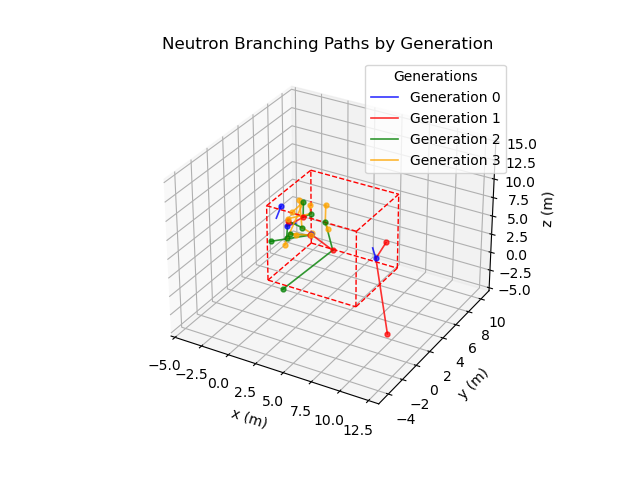

In [24]:
display(test.trajectories_graph)

**Figure 1.** A plot of the Neutron trajectories given the initial conditions of 4 starting neutrons, an $8 \times 6 \times 10$ meter box, and a maximal generation depth of 3. The mechanics of a singular simulation can be verified by observing the tree-like structure of the neutron paths. Each starting neutron produces a distinct tree of furthered neutrons, but neutrons that end beyond the limits of the box at any generation are untracked and all remaining trees are ended at the maximal generation. 

## Simulation Analysis

**Code Block Summary:** (`get_neutrons_in_each_generation`) Calculates the total number of neutrons in each generation by using the previous traversal method `traverse_tree` and building a histogram based on the generation index. Electrons that are lost are not considered in this count.

In [25]:
def get_neutrons_in_each_generation(tree: NeutronNode) -> np.array:
    """
    Counts the number of neutrons in each generation
    """
    counts = []

    for neutron, generation in traverse_tree(tree):
        if len(counts) <= generation:
            counts.append(0)
        if not neutron.lost:
            counts[generation] += 1

    return np.array(counts)

**Code Block Summary:** (`calculate_k_values`) Calculates the replication factor $k$ for each generation based on the list of neutrons in each generation for a given neutron tree using the formula $k_{i} = \frac{n_{i}}{n_{i-1}}$ where $n_i$ is the number of neutrons for generation $i$.

In [26]:
def calculate_k_values(tree: NeutronNode):
    """
    From a neutron tree, return an array of k 
    values (n_next / n_current) for each generation. 
    """
    counts = get_neutrons_in_each_generation(tree)
    return counts[1:] / counts[:-1]

**Code Block Summary:** (`simulate_all`) This code repeats a given simulation and calculates the mean, standard deviation, and standard error for $k$ alongside a bar plot of $k$ values for each generation obtained for given number of replications `m_reps`, and this graph can be used for validation against the produced $k$ values based on Monte-Carlo expectations.

In [27]:
@dataclass
class GenerationData:
    """
    Helper structure for storing k value 
    data and a histogram for each generation
    """
    k_values_raw: np.array   = None
    k_mean:       np.float64 = np.nan
    k_std_dev:    np.float64 = np.nan
    k_std_err:    np.float64 = np.nan
    
    histogram: Image = None

@dataclass
class MonteCarloResults:
    generations:   list[GenerationData] = None
    mean_k_values: np.array             = None
    k_value_plot:  Image                = None

In [28]:
def monte_carlo(dimensions: list[float], num_initial_neutrons: int, 
                num_replications: int,   max_generation: int, 
                plot: bool = False,      debug_print: bool = False):
    """
    Performs a Monte Carlo simulation by repeating a simulation of
    a set of initial conditions (`dimensions`, `num_initial_neutrons`, 
    `max_generation`) for `num_replications`.
    """
    # saves the data
    generation_data = [[] for _ in range(max_generation)]
    start_time = time.time()
    
    # index and interval for debugging
    interval = max(num_replications // 10, 1)
    
    # repeats the simulation for `num_replications`
    for i in range(num_replications):
        simulation_result = simulate(
            max_generation, 
            dimensions,   
            num_initial_neutrons, 
            plot=False
        ).result_trees
        
        # then append the results for each tree
        for tree in simulation_result:
            k_values = calculate_k_values(tree)
            for j, k in enumerate(k_values):
                generation_data[j].append(k)
                
        # Debug Print
        if debug_print and (i+1) % interval == 0:
            print(f'{((i+1) / num_replications) * 100:.0f}% - Replication {i+1}/{num_replications}')

    results = MonteCarloResults()
    results.generations   = []
    results.mean_k_values = []
    
    for gen in range(len(generation_data)):
        data = GenerationData()
        
        data.k_values_raw = np.array(generation_data[gen])
        
        if data.k_values_raw.size > 0:
            data.k_mean    = np.mean(data.k_values_raw)
            data.k_std_dev = np.std(data.k_values_raw)
            data.k_std_err = data.k_std_dev / np.sqrt(data.k_values_raw.size)
            results.mean_k_values.append(data.k_mean)
        
        if plot:
            plt.figure(figsize=(6, 4))

            # Histogram
            plt.hist(
                data.k_values_raw,
                bins=10,
                alpha=0.6,
                edgecolor="black",
                color=plt.get_cmap("viridis")(gen / max(1, max_generation-1))
            )

            # Vertical line for mean
            plt.axvline(data.k_mean, color='red', linestyle="--", linewidth=1.5)

            # Titles and labels
            plt.title(f"Generation {gen} to {gen+1}")
            plt.xlabel("k value")
            plt.ylabel("Frequency")
            plt.grid(alpha=0.3)

            # Text box with stats
            plt.text(
                0.95, 0.95,
                f"$\\bar{{k}}$={data.k_mean:.3f}\n±{data.k_std_err:.3f} (stderr)\nσ={data.k_std_dev:.3f}",
                verticalalignment='top',
                horizontalalignment='right',
                transform=plt.gca().transAxes,
                fontsize=10,
                bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray')
            )

            plt.tight_layout()
            data.histogram = save_graph_and_close()
            
        results.generations.append(data)
    
    results.mean_k_values = np.asarray(results.mean_k_values)
    
    if plot:
        plt.figure()
        plt.title('Mean Replication Rate by Generation')
        plt.plot(np.arange(results.mean_k_values.size),
                 results.mean_k_values, 
                 label='k')
        plt.xticks(np.arange(results.mean_k_values.size))
        plt.xlabel('Generation')
        plt.ylabel('Replication Rate')
        results.k_value_plot = save_graph_and_close()
        
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    if debug_print:
        print(f"Executed in {int(elapsed_time)} s {int((elapsed_time - int(elapsed_time)) * 1000)} ms")
    
    return results

## Example Monte Carlo Test

**Code Block Summary:** This is an example Monte Carlo simulation for 3 generations (with a singular starting neutron), 250 initial neutrons, 300 replications, and a $10 \times 10 \times 10$ box.

In [29]:
example_mc_results = monte_carlo(
    dimensions            = (10,10,10), 
    num_initial_neutrons  = 250, 
    num_replications      = 300,
    max_generation        = 3,
    plot        = True,
    debug_print = True
)

10% - Replication 30/300
20% - Replication 60/300
30% - Replication 90/300
40% - Replication 120/300
50% - Replication 150/300
60% - Replication 180/300
70% - Replication 210/300
80% - Replication 240/300
90% - Replication 270/300
100% - Replication 300/300
Executed in 8 s 840 ms


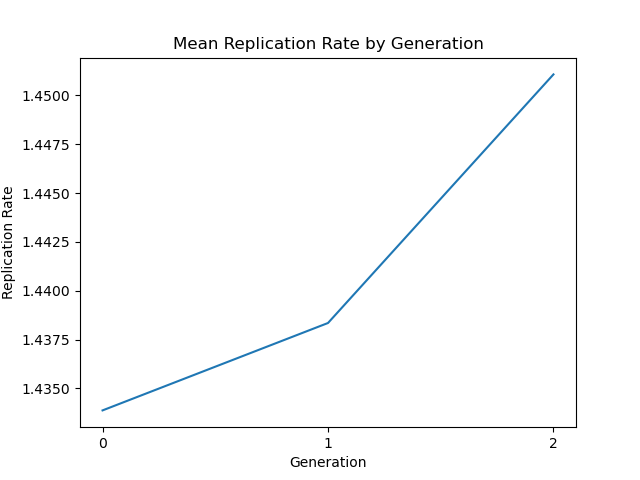

In [83]:
display(example_mc_results.k_value_plot)

**Figure 2.** A clear upward trend in mean replication rate as a function of generation can be seen, and this seems counterintuitive at first, as initial Neutrons are statistically most likely to be toward the exact center of the box, so later Neutrons become more likely to spread outward radially (which implies the opposite trend). However, this trend of increase is likely the result of the mathematical spectrum of possible $k$ values that can be produced at each neutron level. The first generation can only ever replicate 0, 1, or 2 neutrons exactly, so an individual neutron $i$ will have exactly $k_i = 0, 1, 2$: a discrete range. So, in short, because the range of possible $k$ values for a given neutron is so limited, the negative contribution from low $k$ values will be much higher.

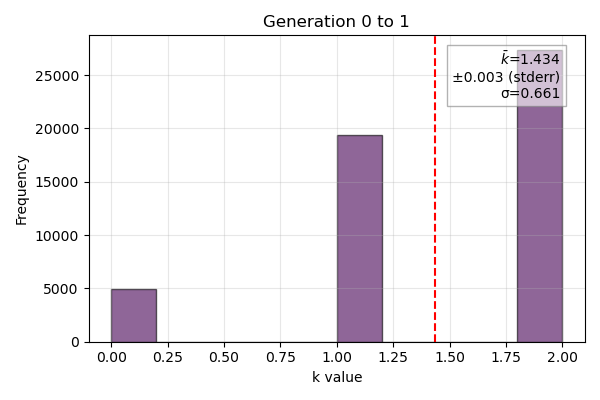

In [31]:
display(example_mc_results.generations[0].histogram)

**Figure 3.** The first generation will usually have a replication rate of $k=2$ or $k=1$ due to the nature of always having to start out within the box (and being more likely to begin closer to the middle than closer to the edge as a result).

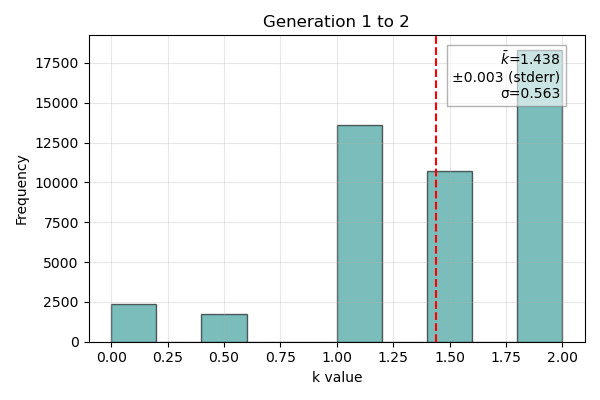

In [32]:
display(example_mc_results.generations[1].histogram)

**Figure 4.** For the next generation, the $k$-values begin to spread out as the successive neutrons become more likely to be in a variety of places within the box. For example, the first neutron may be most likely to begin closer to the middle, but subsequent neutrons become more likely to become closer to the edges of the box. However, the mean $k$ value is slowly increasing as compared to the first generation simply due to the number of total children that can possibly be generated in each successive generation increasing by $2^n - 2^{n-1}$ for each generation $n$, and furthermore, this also means that as the generations grow, the standard deviation $\sigma$ should decrease due to the sheer number of neutrons making individual neutrons being lost have less effect on the overall $k$ value.

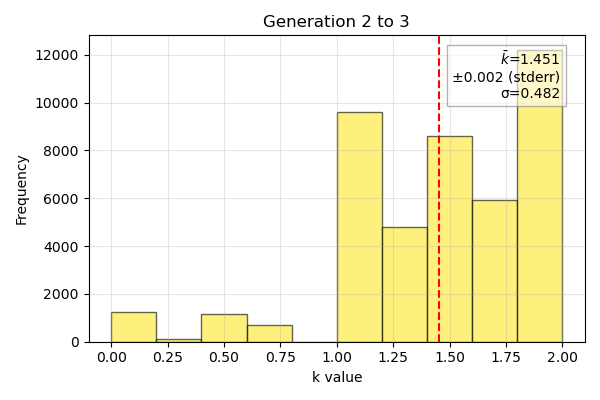

In [33]:
display(example_mc_results.generations[2].histogram)

**Figure 5.** The aforementioned pattern in Figure 3. is continued here, as the spread of $k$ values continues to further out. As expected, $k$ has increased and the standard deviation has decreased due to the sheer number of neutrons that exist at this generation. 

# Phase Investigation

**Code Block Summary:** (`calculate_dimensions`) This is a helper function to obtain the dimensions of the box given an area and aspect ratio. This can be done mathematically. 

Let $V$ be the area and $R$ be the aspect ratio, and $w$ be the width and $h$ be the height. As a somewhat trivial definition, to keep the phase only in terms of $w$ and $h$, we can define the length as $\ell = \frac{1}{2}(w+h)$ (the average between the two values).

Therefore, the aspect ratio (which can still be kept 2-dimensional) is $R = \frac{w}{h}$ and the volume is 
$$\begin{equation}
V = wh\ell = wh\frac{1}{2}(w + h).
\end{equation}$$ 
and knowing that $w = Rh$, this becomes
$$V = \frac{1}{2} Rh^3 (R + 1)$$
which can be rewritten as
$$\begin{equation}
h = \left(\frac{2V}{R(R+1)}\right)^\frac{1}{3}
\end{equation}$$

In [34]:
def calculate_dimensions(aspect_ratio: float, volume: float):
    height = (2 * volume / (aspect_ratio * (aspect_ratio + 1))) ** (1/3)
    width  = aspect_ratio * height
    length = (width + height) / 2
    
    return (width, length, height)

**Code Block Summary:** This is the actual phase investigation, which performs `monte_carlo` for each of the box sizes produced given a domain of aspect ratios $(R_{min}, R_{max})$ and a domain of areas $(V_{min}, V_{max})$, alongside a number of starting neutrons, and number of replications per condition coordinate $(R,V)$. 

In [108]:
@dataclass
class ContourResults:
    contour_plots: list[Image] = None

def generate_contour(aspect_ratio_range: tuple, area_range: tuple, max_generation: int = 3,
                     num_initial_neutrons: int = 1, num_replications: int = 1,
                     debug_print: bool = False):
    """
    Explores the phase space of (R,V) and generates the overall contour for mean k across generations
    based on calling monte_carlo for each phase coordinate.
    """
    start_time = time.time()
    
    # Store some of the parameters to explore the contour
    contour_params = (max_generation, num_initial_neutrons, num_replications)
    
    # Build the phase
    aspect_ratio_domain = np.linspace(*aspect_ratio_range)
    area_domain = np.linspace(*area_range)
    
    R, V = np.meshgrid(aspect_ratio_domain, area_domain)
    K = np.zeros((max_generation, aspect_ratio_domain.size, area_domain.size), dtype=float)
    total_sims = aspect_ratio_domain.size * area_domain.size
    
    # index and interval for debugging
    idx = 0
    interval = max(total_sims // 10, 1)
    
    # Iterate over the Phase
    for i, aspect_ratio in enumerate(aspect_ratio_domain):
        for j, volume in enumerate(area_domain):
            idx += 1
            
            dimensions = calculate_dimensions(aspect_ratio, volume)
            simulation = monte_carlo(dimensions, num_initial_neutrons,
                                     num_replications, max_generation, plot=False)
            
            for gen, k_value in enumerate(simulation.mean_k_values):
                K[gen,j,i] = k_value
            
            # Debug Print
            if debug_print and idx % interval == 0:
                print(f'{(idx / total_sims) * 100:.0f}% - Iteration {idx}/{total_sims}')
    
    # Plotting
    results = ContourResults()
    ncols = int(np.ceil(np.sqrt(max_generation)))
    nrows = int(np.ceil(max_generation / ncols))
    
    padding = 5
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols + padding, 4*nrows + padding))
    axes = axes.flatten()  # flatten in case it's a 2D array of axes

    vmin = np.min(K)
    vmax = np.max(K)

    for gen in range(max_generation):
        ax = axes[gen]
        cp = ax.contourf(R, V, K[gen], levels=20, cmap='viridis', vmin=vmin, vmax=vmax)
        ax.set_xlabel('Aspect Ratio $w/h$')
        ax.set_ylabel('Volume ($m^3$)')
        ax.set_title(f'Generation {gen} to {gen+1}')

    # Hide any extra axes if max_generation is not a perfect grid
    for ax in axes[max_generation:]:
        ax.set_visible(False)
        
    # Add **one shared colorbar** for the whole figure
    fig.colorbar(cp, ax=axes[:max_generation], orientation='vertical', label='Mean K')

    # Save the combined figure
    results.contour_plots = save_graph_and_close()
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    if debug_print:
        print(f"Executed in {int(elapsed_time)} s {int((elapsed_time - int(elapsed_time)) * 1000)} ms")
    
    return results, contour_params

**Code Block Summary:** This is the exploration code for a range of 10 aspect ratios from $R=1$ to $R=4$ and 10 areas from $A=1$ to $A=200$, given 10 starting neutrons, 20 replications, and 4 generations.

In [109]:
contour_results, contour_params = generate_contour(
    aspect_ratio_range   = (1/10,  10, 20), 
    area_range           = (1,   200, 20),
    max_generation       = 4,
    num_initial_neutrons = 10, 
    num_replications     = 20,
    debug_print          = True
)

10% - Iteration 40/400
20% - Iteration 80/400
30% - Iteration 120/400
40% - Iteration 160/400
50% - Iteration 200/400
60% - Iteration 240/400
70% - Iteration 280/400
80% - Iteration 320/400
90% - Iteration 360/400
100% - Iteration 400/400
Executed in 4 s 810 ms


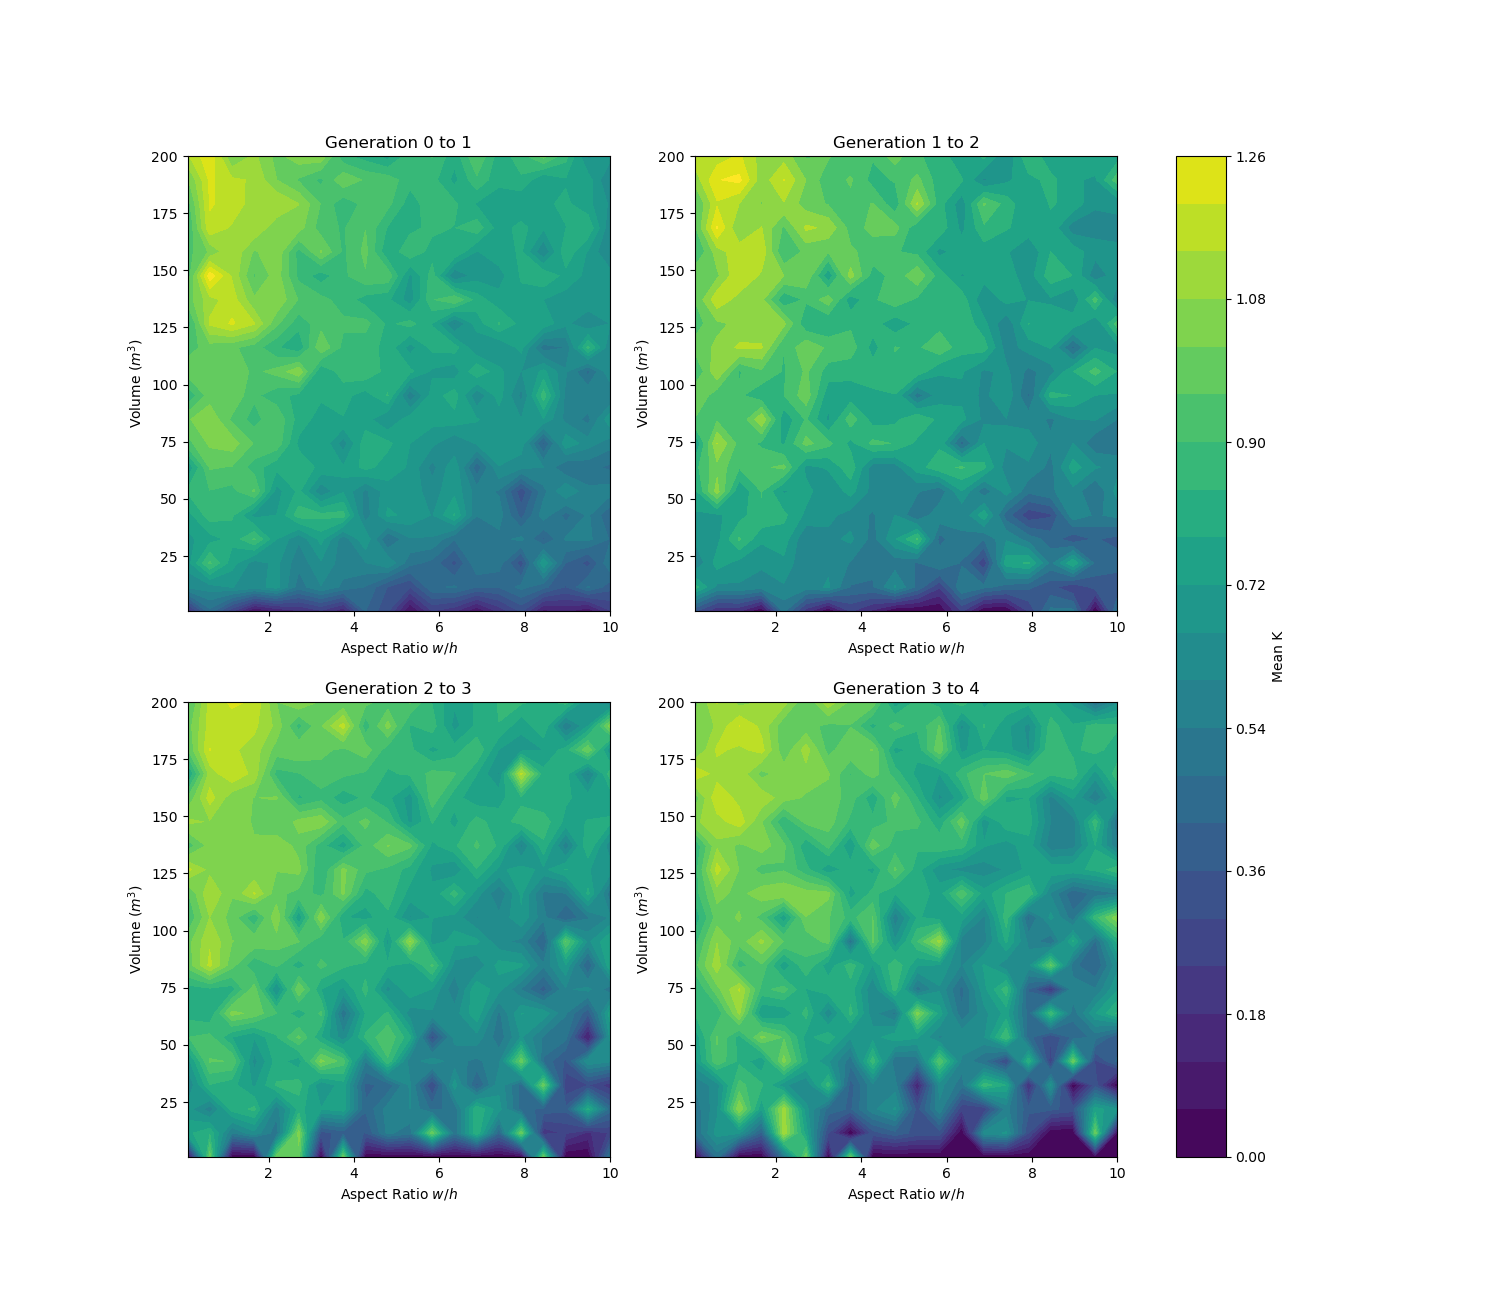

In [110]:
display(contour_results.contour_plots)

**Figure 6.** In terms of aspect ratio, the model clearly favors more cubic boxes around with aspect ratios of $1:1$ or $R=1$, and in terms of volume, higher volumes are much more favorable across the board.

**Code Block Summary:** This code will allow us to explore the phase by selecting individual coordinates, and that way, we can understand the results we are seeing. It works by taking the parameters we selected for our contour previously and performing the simulation for given coordinates $(R,V)$, and it returns an example simulation result alongside a full Monte Carlo simulation at that coordinate.

In [84]:
@dataclass
class PhaseCoordinateData:
    example_simulation: SimulationResult
    monte_carlo_result: list[GenerationData]

def examine_contour_coordinate(aspect_ratio, area, contour_params):
    """
    Performs the Monte-Carlo simulation for a phase coordinate
    (R,V) over again, and also provides an example simulation
    alongside the Monte-Carlo results so that we can observe
    what is going on at a certain coordinate.
    """
    max_generation, num_initial_neutrons, num_replications = contour_params
    dimensions = calculate_dimensions(aspect_ratio, area)
    example_simulation = simulate(max_generation, dimensions, num_initial_neutrons, plot = True)
    
    # num_replications can be doubled to make this Monte-Carlo simulation more accurate
    monte_carlo_result = monte_carlo(dimensions, num_initial_neutrons, num_replications * 2, max_generation, plot=True)
    
    return PhaseCoordinateData(example_simulation, monte_carlo_result)

## Phase Exploration: Edge Cases

### Edge Case 1: The Absolute Maxima: $(R,V) = (1, 200)$

**Code Block Summary:** Now, we can explore the phase a bit to understand what is going on in the contour, and why it seems to favor wide boxes over tall boxes. We can begin with a global maxima of stability, $(R,V) \approx (1, 200)$: 

In [111]:
edge_case_1 = examine_contour_coordinate(1, 200, contour_params)

In [112]:
for tree in edge_case_1.example_simulation.result_trees:
    print_tree(tree)

⤷ ACTIVE  start=(1.21, 1.54, 2.79)  →  end=(1.26, 0.85, 2.28)
  ⤷ ACTIVE  start=(1.26, 0.85, 2.28)  →  end=(1.26, 0.84, 2.3)
    ⤷ LOST  start=(1.26, 0.84, 2.3)  →  end=(0.59, 0.64, -0.71)
    ⤷ LOST  start=(1.26, 0.84, 2.3)  →  end=(-0.83, -3.37, 4.49)
  ⤷ ACTIVE  start=(1.26, 0.85, 2.28)  →  end=(1.06, 1.77, 3.08)
    ⤷ ACTIVE  start=(1.06, 1.77, 3.08)  →  end=(0.35, 0.93, 1.05)
      ⤷ ACTIVE  start=(0.35, 0.93, 1.05)  →  end=(0.37, 0.91, 1.0)
        ⤷ LOST  start=(0.37, 0.91, 1.0)  →  end=(-1.94, 1.15, 2.79)
        ⤷ LOST  start=(0.37, 0.91, 1.0)  →  end=(-1.9, -0.57, 1.28)
      ⤷ LOST  start=(0.35, 0.93, 1.05)  →  end=(-4.29, 3.78, -3.23)
    ⤷ ACTIVE  start=(1.06, 1.77, 3.08)  →  end=(0.55, 2.22, 4.17)
      ⤷ ACTIVE  start=(0.55, 2.22, 4.17)  →  end=(1.2, 2.18, 4.47)
        ⤷ LOST  start=(1.2, 2.18, 4.47)  →  end=(0.58, 2.8, 12.36)
        ⤷ LOST  start=(1.2, 2.18, 4.47)  →  end=(1.1, 4.66, 6.24)
      ⤷ LOST  start=(0.55, 2.22, 4.17)  →  end=(1.49, 2.42, 6.16)
⤷ ACTIVE  sta

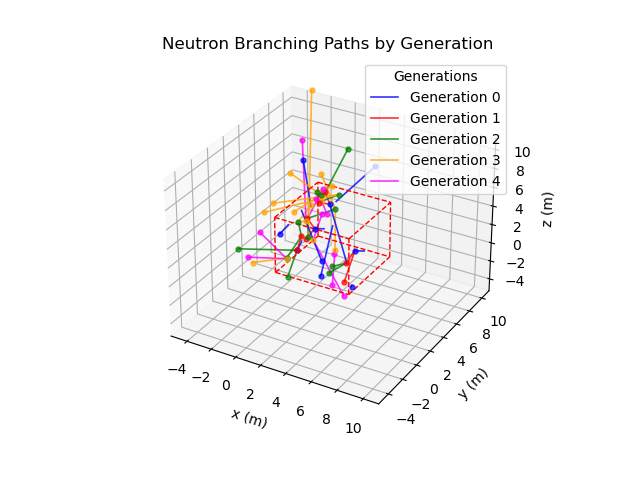

In [113]:
display(edge_case_1.example_simulation.trajectories_graph)

**Figure 7.** The trajectory plot for this simulation seems standard, with 

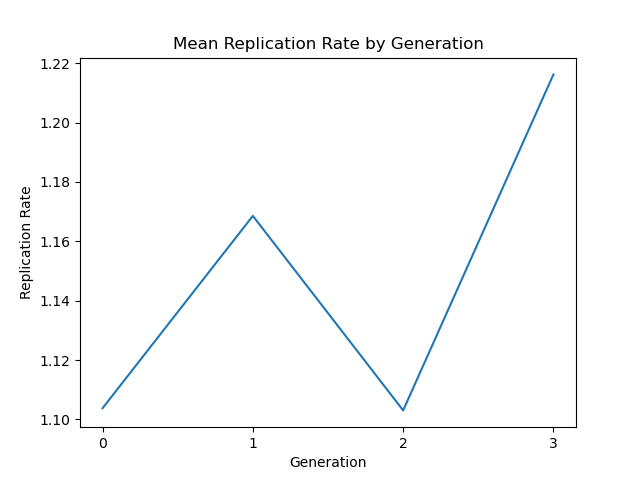

In [114]:
display(edge_case_1.monte_carlo_result.k_value_plot)

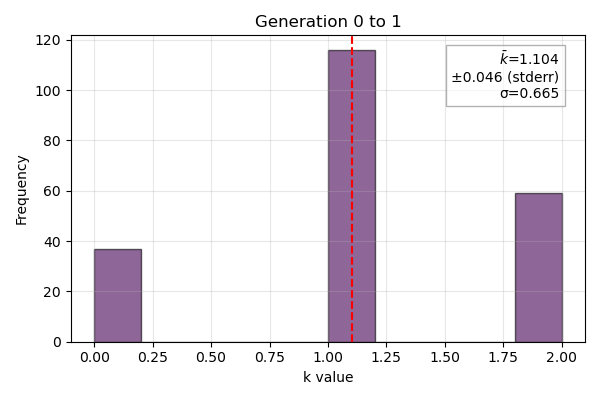

In [115]:
display(edge_case_1.monte_carlo_result.generations[0].histogram)

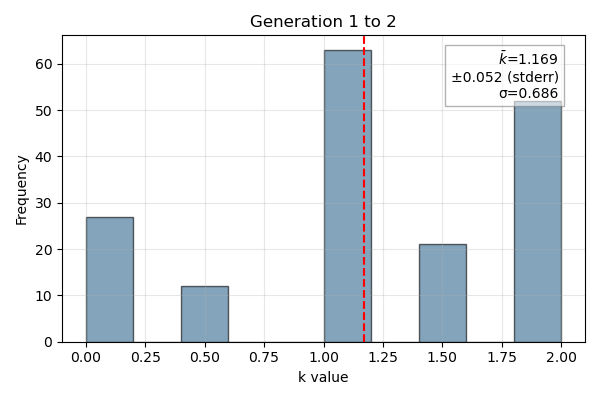

In [116]:
display(edge_case_1.monte_carlo_result.generations[1].histogram)

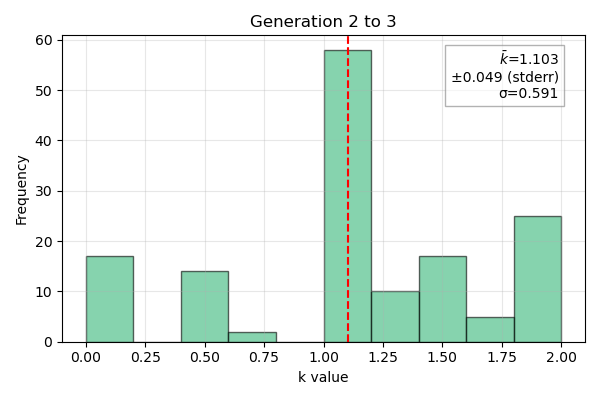

In [117]:
display(edge_case_1.monte_carlo_result.generations[2].histogram)

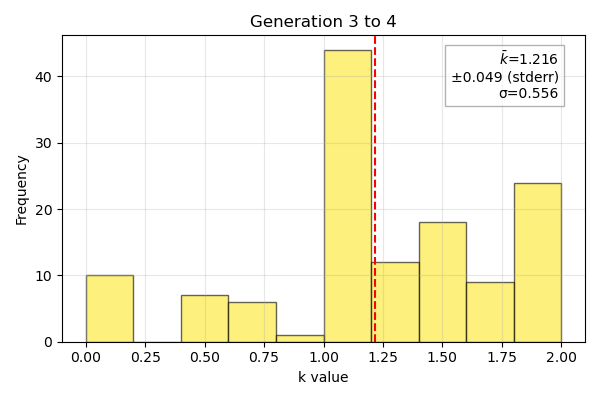

In [120]:
display(edge_case_1.monte_carlo_result.generations[3].histogram)

### Edge Case 2: Dead Region $(R,V)=(10,1)$

In [121]:
edge_case_2 = examine_contour_coordinate(10, 1, contour_params)

In [122]:
for tree in edge_case_2.example_simulation.result_trees:
    print_tree(tree)

⤷ LOST  start=(2.23, 1.36, 0.19)  →  end=(2.36, 1.42, -0.32)
⤷ LOST  start=(2.59, 0.78, 0.21)  →  end=(2.55, 1.27, 1.02)
⤷ LOST  start=(1.25, 1.29, 0.23)  →  end=(0.65, 0.94, 1.22)
⤷ LOST  start=(1.75, 0.31, 0.22)  →  end=(2.49, -0.19, 0.82)
⤷ LOST  start=(0.88, 1.44, 0.01)  →  end=(-1.49, 2.82, 0.32)
⤷ LOST  start=(1.48, 1.25, 0.13)  →  end=(2.77, 1.21, 1.42)
⤷ LOST  start=(0.88, 0.05, 0.26)  →  end=(0.89, 0.13, 1.95)
⤷ LOST  start=(0.39, 0.02, 0.25)  →  end=(3.18, -1.75, 3.33)
⤷ LOST  start=(2.53, 1.03, 0.02)  →  end=(3.33, 1.66, 2.46)
⤷ LOST  start=(1.67, 0.02, 0.0)  →  end=(-0.05, 0.44, -1.29)


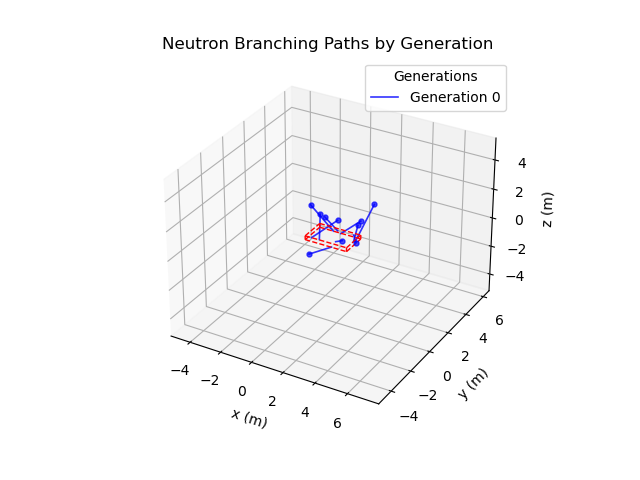

In [123]:
display(edge_case_2.example_simulation.trajectories_graph)

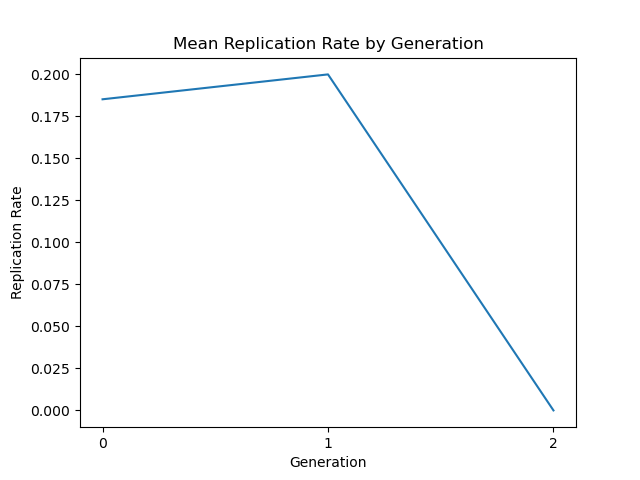

In [124]:
display(edge_case_2.monte_carlo_result.k_value_plot)

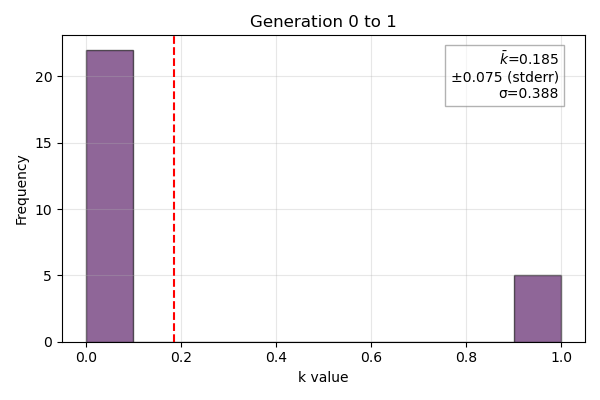

In [125]:
display(edge_case_2.monte_carlo_result.generations[0].histogram)

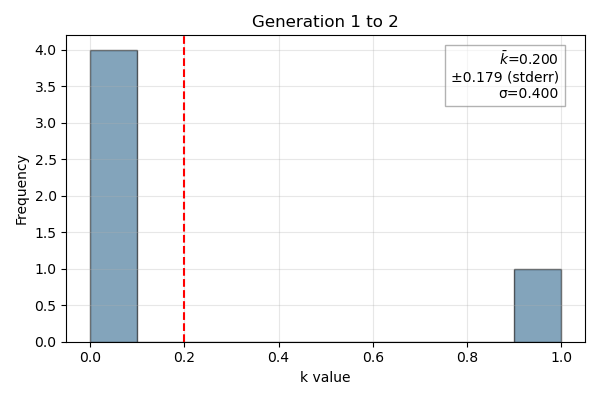

In [126]:
display(edge_case_2.monte_carlo_result.generations[1].histogram)

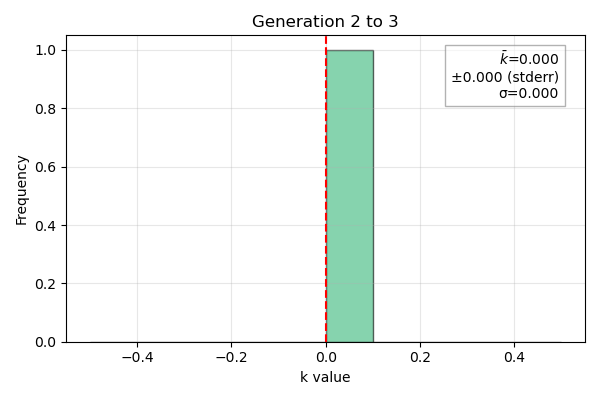

In [127]:
display(edge_case_2.monte_carlo_result.generations[2].histogram)

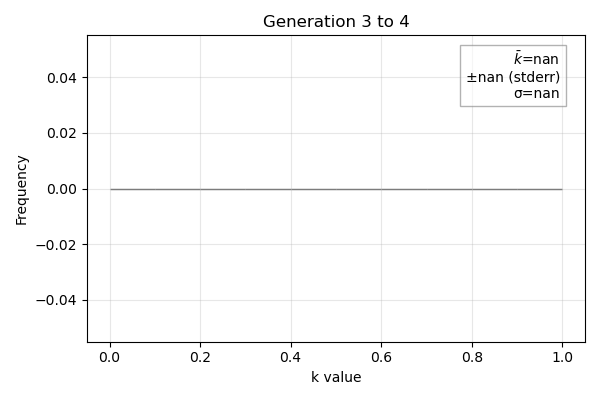

In [128]:
display(edge_case_2.monte_carlo_result.generations[3].histogram)

### Edge Case 3: 

## Summary of Findings

### Conclusion 

### Limitations

### Future Work

This research begets the following questions:

1. What $k$-value pattern would be observed for incredibly high generation counts?

I hypothesize that this would become a gaussian curve at higher generation counts, as the $k$-value must reasonably approach zero (assuming the box size is small enough that it can reasonably eventually capture all of the neutrons). However, due to the exponential growth of the neutron trees, it isn't realistically feasible to explore the generational dependence of the $k$-values for long-run simulations, as even as little as 6 generations would require 20 generations would require $2^{20}$ (or well over a million) neutrons to be tracked. In physical reality, this could be hundreds of generations, so drawing a good conclusion on this pattern would require a strongly-fixed size to limit the maximal generation depth and get a characteristic curve for this dependence. 

2. At what size could this simulation reasonably run "forever" (or, mathematically, a really long time)?

## Bibliography

1. https://docs.python.org/3/library/dataclasses.html
2. https://docs.python.org/3/library/collections.html#collections.deque
3. https://pypi.org/project/pillow/
4. https://docs.python.org/3/library/io.html
5. https://cs110.students.cs.ubc.ca/reference/design-recipes.html#GenRec
6. https://docs.python.org/3/library/itertools.html
7. https://matplotlib.org/3.3.3/api/_as_gen/mpl_toolkits.mplot3d.axes3d.Axes3D.html
8. https://www.itl.nist.gov/div898/handbook/eda/section3/eda35c.htm

# Appendix

## A. Validation Tasks

### A-1 Flat-Printing Trees

### A-2 Unit Tests

## B. Reflection Questions

### B-1. Coding Approaches (A)

> How well did you apply and extend your coding knowledge in this project? Consider steps you took to make the code more efficient, readable and/or concise. Discuss any new-to-you coding techniques, functions or python packages that you learned how to use. Reflect on any unforeseen coding challenges you faced in completing this project.

### B-2. Coding Approaches (B)

> Highlight an aspect of your code that you feel you did particularily well. Discuss an aspect of your code that would benefit the most from further effort.

### B-3. Simulation Physics and Investigation (A)

> How well did you apply and extend your physical modelling and scientific investigation skills in this project? Consider the phase space you chose to explore and how throroughly you explored it. Consider how you translated physics into code and if appropriate any new physics you learned or developed a more thorough understanding of.

### B-4. Simulation Physics and Investigation (B)

> Highlight something you feel you did particularily well in terms of the context of your simulation, the physical modelling that you did or the investigation you performed. Discuss an aspect of these dimensions of your project that would benefit the most from further effort.

### B-5. Effectiveness of Your Communication

> Highlight something you feel you did particularily well in your visualizations or written communication. Discuss an aspect of your visualizations or written communication that would benefit the most from further effort.

# Acknowledgements